In [252]:
import sys
sys.path.append("../")

from SALib.sample import sobol
from network_model import *
from tqdm import tqdm
import numpy as np
import pickle
import lzma
import os


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
def gini(W):
    n = len(W)
    total = 0
    for i in range(n):
        total += sum(np.abs(W[i]-W))
    return total / (2 * n**2 * np.mean(W))

In [3]:
def category_1(data):
    decreasing = []
    for i in range(len(data)):
        d = data[i]
        mono_dec = True
        for row in d:
            if max(row[1:] - row[:-1]) > 0:
                mono_dec = False
                break
        if mono_dec:
            decreasing.append(i)
    return decreasing


def category_2(data, ignore):
    increase_less_initial = []
    for i in range(len(data)):
        if i not in ignore:
            d = data[i]
            if np.all(np.max(data[i], axis=1) == data[i][:,0]):
                increase_less_initial.append(i)
    return increase_less_initial


def category_3(data, ignore):
    surpass_end_poor = []
    for i in range(len(data)):
        if i not in ignore:
            if max(data[i].T[-1]) < 0.1:
                surpass_end_poor.append(i)
    return surpass_end_poor


def category_4(data, ignore):
    two_equilibria_less_initial = []
    for i in range(len(data)):
        if i not in ignore:
            if np.all(data[i].T[-1] < data[i].T[0]):
                two_equilibria_less_initial.append(i)
    return two_equilibria_less_initial


def category_5(data, ignore):
    two_equilibria_richer = []
    for i in range(len(data)):
        if i not in ignore:
            two_equilibria_richer.append(i)
    return two_equilibria_richer

In [4]:
directories = ["../data/sobol/concat_W_arrays", 
               "../data/sobol/concat_W_arrays_random", 
               "../data/sobol/concat_W_arrays_cpt"]

labels = ["MPT (Holme-Kim)", 
          "MPT (Random)", 
          "CPT (Holme-Kim)"]

communities_file = ["../augmented_communities.pickle", 
                    "../augmented_communities_random.pickle",
                    "../augmented_communities.pickle"]

# Analysis at agent level

In [13]:
gini_cutoffs = None
percentage_results = {}

for dir_idx, D in enumerate(directories):
    
    print(f"Running analysis for {labels[dir_idx]}...")
    
    category_counts = {i:0 for i in range(7)}
    gini_coefficients = []
    
    for f in tqdm(os.listdir(D)):

        data = pickle.load(lzma.open(os.path.join(D,f)))
        
        cat1 = category_1(data)
        cat2 = category_2(data, cat1)
        cat3 = category_3(data, cat1+cat2)
        cat4 = category_4(data, cat1+cat2+cat3)
        cat5 = category_5(data, cat1+cat2+cat3+cat4)
        
        assert len(cat1+cat2+cat3+cat4+cat5) == len(data)

        gini_coefficients += [gini(data[i].T[-1]) for i in cat5]

        for i,cat in enumerate([cat1, cat2, cat3, cat4]):
            category_counts[i] += len(cat)

    if gini_cutoffs is None:
        sorted_coeffs = np.array(sorted(gini_coefficients))
        split_arrays = np.array_split(sorted_coeffs, 3)
        gini_cutoffs = [arr[-1] for arr in split_arrays]

    gini_categories = {cutoff:[] for cutoff in gini_cutoffs}
    for coeff in gini_coefficients:
        for key in gini_categories:
            if coeff <= key:
                gini_categories[key].append(coeff)
                break
 
    for i,cutoff in enumerate(gini_categories):
        category_counts[4+i] += len(gini_categories[cutoff])

    L = sum(category_counts.values())
    percentage_results[labels[dir_idx]] = [100*category_counts[i]/L for i in range(len(category_counts))]

    print("--- SUMMARY STATISTICS ---")
    print(f"CATEGORY 1: {percentage_results[labels[dir_idx]][0]:.3f}%")
    print(f"CATEGORY 2: {percentage_results[labels[dir_idx]][1]:.3f}%")
    print(f"CATEGORY 3: {percentage_results[labels[dir_idx]][2]:.3f}%")
    print(f"CATEGORY 4: {percentage_results[labels[dir_idx]][3]:.3f}%")
    print(f"CATEGORY 5 (gini <= {gini_cutoffs[0]:.4f}): {percentage_results[labels[dir_idx]][4]:.3f}%")
    print(f"CATEGORY 6 (gini <= {gini_cutoffs[1]:.4f}): {percentage_results[labels[dir_idx]][5]:.3f}%")
    print(f"CATEGORY 7 (gini <= {gini_cutoffs[2]:.4f}): {percentage_results[labels[dir_idx]][6]:.3f}%")
    print("\n\n")

Running analysis for CPT (Holme-Kim)...


100%|██████████| 10/10 [31:47<00:00, 190.71s/it]


--- SUMMARY STATISTICS ---
CATEGORY 1: 41.638%
CATEGORY 2: 6.852%
CATEGORY 3: 49.096%
CATEGORY 4: 0.473%
CATEGORY 5 (gini <= 0.9911): 0.647%
CATEGORY 6 (gini <= 0.9959): 0.647%
CATEGORY 7 (gini <= 0.9995): 0.647%



Running analysis for CPT (Random)...


100%|██████████| 10/10 [33:42<00:00, 202.22s/it]


--- SUMMARY STATISTICS ---
CATEGORY 1: 41.888%
CATEGORY 2: 6.956%
CATEGORY 3: 48.654%
CATEGORY 4: 0.480%
CATEGORY 5 (gini <= 0.9911): 0.807%
CATEGORY 6 (gini <= 0.9959): 0.650%
CATEGORY 7 (gini <= 0.9995): 0.565%



Running analysis for MPT (Holme-Kim)...


100%|██████████| 10/10 [2:01:39<00:00, 729.94s/it]

--- SUMMARY STATISTICS ---
CATEGORY 1: 11.111%
CATEGORY 2: 0.000%
CATEGORY 3: 62.919%
CATEGORY 4: 3.387%
CATEGORY 5 (gini <= 0.9911): 17.213%
CATEGORY 6 (gini <= 0.9959): 2.959%
CATEGORY 7 (gini <= 0.9995): 2.411%





# Analysis at community level

In [5]:
gini_cutoffs = None
percentage_results = {}

for dir_idx, D in enumerate(directories):
    
    with open(communities_file[dir_idx], "rb") as f:
        communities = pickle.load(f) 
    community_keys = sorted(list(communities.keys()))[:-1]
    
    print(f"Running analysis for {labels[dir_idx]}...")
    
    category_counts = {i:0 for i in range(7)}
    gini_coefficients = []
    
    for f in tqdm(os.listdir(D)):
        data = pickle.load(lzma.open(os.path.join(D,f)))
        data_communities = np.zeros((data.shape[0], len(community_keys), data.shape[2]))
        for c in community_keys:
            for i in range(len(data)):
                data_communities[i][c] = np.mean(data[i][communities[c]], axis=0)
        
        data = data_communities
        cat1 = category_1(data)
        cat2 = category_2(data, cat1)
        cat3 = category_3(data, cat1+cat2)
        cat4 = category_4(data, cat1+cat2+cat3)
        cat5 = category_5(data, cat1+cat2+cat3+cat4)
        
        assert len(cat1+cat2+cat3+cat4+cat5) == len(data)

        gini_coefficients += [gini(data[i].T[-1]) for i in cat5]

        for i,cat in enumerate([cat1, cat2, cat3, cat4]):
            category_counts[i] += len(cat)

    if gini_cutoffs is None:
        sorted_coeffs = np.array(sorted(gini_coefficients))
        split_arrays = np.array_split(sorted_coeffs, 3)
        gini_cutoffs = [arr[-1] for arr in split_arrays]

    gini_categories = {cutoff:[] for cutoff in gini_cutoffs}
    for coeff in gini_coefficients:
        for key in gini_categories:
            if coeff <= key:
                gini_categories[key].append(coeff)
                break
 
    for i,cutoff in enumerate(gini_categories):
        category_counts[4+i] += len(gini_categories[cutoff])

    L = sum(category_counts.values())
    percentage_results[labels[dir_idx]] = [100*category_counts[i]/L for i in range(len(category_counts))]

    print("--- SUMMARY STATISTICS ---")
    print(f"CATEGORY 1: {percentage_results[labels[dir_idx]][0]:.3f}%")
    print(f"CATEGORY 2: {percentage_results[labels[dir_idx]][1]:.3f}%")
    print(f"CATEGORY 3: {percentage_results[labels[dir_idx]][2]:.3f}%")
    print(f"CATEGORY 4: {percentage_results[labels[dir_idx]][3]:.3f}%")
    print(f"CATEGORY 5 (gini <= {gini_cutoffs[0]:.4f}): {percentage_results[labels[dir_idx]][4]:.3f}%")
    print(f"CATEGORY 6 (gini <= {gini_cutoffs[1]:.4f}): {percentage_results[labels[dir_idx]][5]:.3f}%")
    print(f"CATEGORY 7 (gini <= {gini_cutoffs[2]:.4f}): {percentage_results[labels[dir_idx]][6]:.3f}%")
    print("\n\n")

Running analysis for CPT (Holme-Kim)...


100%|██████████| 10/10 [23:52<00:00, 143.26s/it]


--- SUMMARY STATISTICS ---
CATEGORY 1: 86.732%
CATEGORY 2: 8.887%
CATEGORY 3: 2.615%
CATEGORY 4: 0.804%
CATEGORY 5 (gini <= 0.9533): 0.321%
CATEGORY 6 (gini <= 0.9864): 0.321%
CATEGORY 7 (gini <= 0.9961): 0.320%



Running analysis for CPT (Random)...


100%|██████████| 10/10 [26:34<00:00, 159.42s/it]


--- SUMMARY STATISTICS ---
CATEGORY 1: 84.826%
CATEGORY 2: 13.708%
CATEGORY 3: 0.199%
CATEGORY 4: 0.454%
CATEGORY 5 (gini <= 0.9533): 0.418%
CATEGORY 6 (gini <= 0.9864): 0.329%
CATEGORY 7 (gini <= 0.9961): 0.067%



Running analysis for MPT (Holme-Kim)...


100%|██████████| 10/10 [20:22<00:00, 122.27s/it]

--- SUMMARY STATISTICS ---
CATEGORY 1: 11.526%
CATEGORY 2: 5.722%
CATEGORY 3: 58.870%
CATEGORY 4: 6.364%
CATEGORY 5 (gini <= 0.9533): 13.934%
CATEGORY 6 (gini <= 0.9864): 2.619%
CATEGORY 7 (gini <= 0.9961): 0.965%





## Erdos-renyi graph...

In [150]:
asdf = nx.erdos_renyi_graph(n=1250, p=0.0032)
nx.is_connected(asdf)

False

In [151]:
components = list(nx.connected_components(asdf))
largest_component = list(components[0])
disconnected_components = list(range(1,len(components)))

for node in disconnected_components:
    asdf.add_edge(list(components[node])[0], np.random.choice(largest_component))
    
assert nx.is_connected(asdf)

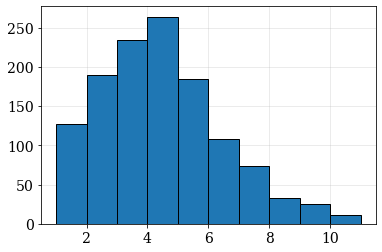

3.9616

In [164]:
degrees = list(dict(asdf.degree).values())
plt.hist(degrees, bins=10, edgecolor="k")
plt.show()

np.mean(degrees)

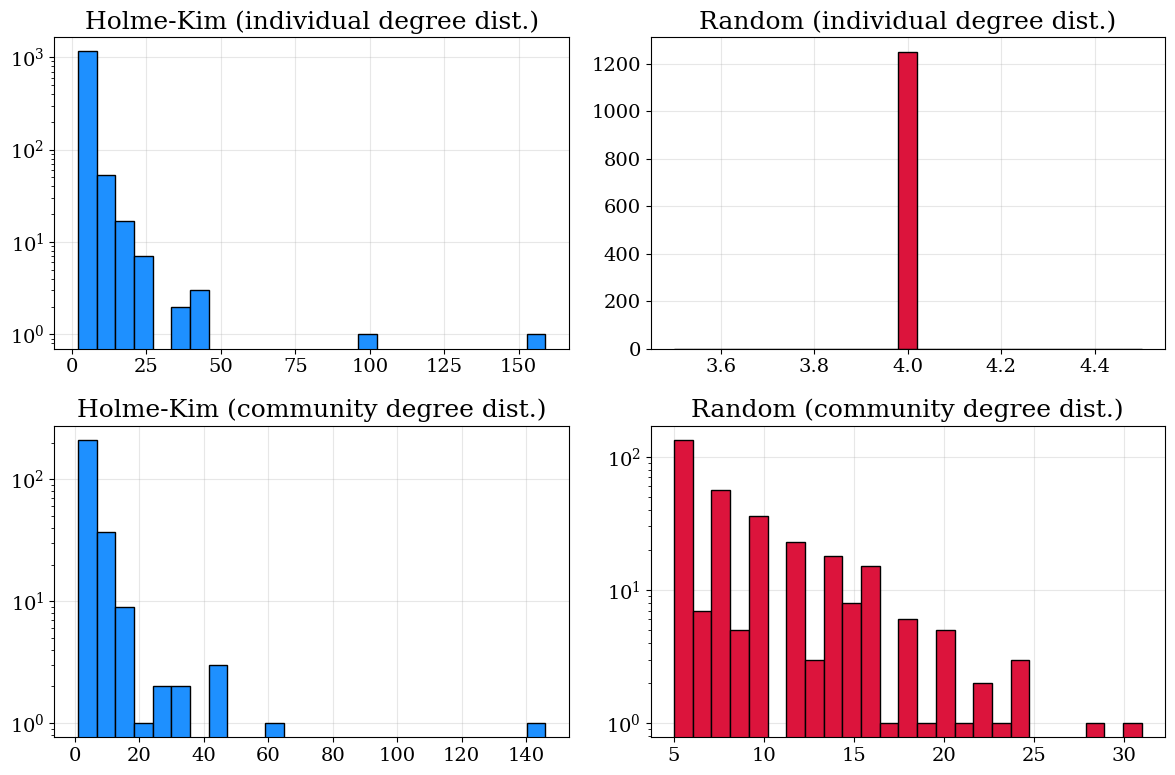

In [282]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

colors = ["dodgerblue", "crimson"]
titles = ["Holme-Kim", "Random"]


for g_idx, file in enumerate(["../graph.pickle", "../random_graph.pickle"]):

    with open(file, "rb") as f:
        G = pickle.load(f)
        
    # plot individual degree distribution
    degrees = list(dict(G.degree).values())
    axs[0][g_idx].hist(degrees, color=colors[g_idx], edgecolor="k", bins=25)
    if g_idx == 0:
        axs[0][g_idx].set_yscale("log")
    axs[0][g_idx].set_title(titles[g_idx] + " (individual degree dist.)")

    communities = list(nx.community.label_propagation_communities(G))
    adjacency = dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())
    node_community_map = get_node_community_map(communities)

    community_adjacency = {}
    for i,c in enumerate(communities):
        community_adjacency[i] = set()
        for node in c:
            node_neighbours = adjacency[node]
            for neighbour in node_neighbours:
                neighbouring_community = node_community_map[neighbour]
                if neighbouring_community != i:
                    community_adjacency[i].add(neighbouring_community)
            
    # plot community degree distribution
    axs[1][g_idx].hist([len(x) for x in list(community_adjacency.values())], 
                    edgecolor="k", bins=25, color=colors[g_idx])
    axs[1][g_idx].set_yscale("log")
    axs[1][g_idx].set_title(titles[g_idx] + " (community degree dist.)")
    
fig.tight_layout()
plt.show()